# Code for the "Task 2" in the Individual Assignment

## Indlæser Imports

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

from scipy.stats import shapiro, ttest_rel

## Indlæser Data

In [103]:
df = pd.read_csv('/Users/valdemarstamm/Desktop/DTU/2. Semester/Kursus i Statistisk Evaluering /Individual assignment/assignment/task_2/HR_data.csv')

# definer features og target variable
X = df[['HR_Mean','HR_Median','HR_std','HR_Min','HR_Max','HR_AUC']]
y = df['Frustrated']
groups = df['Individual']

# Fordeling af Frustration

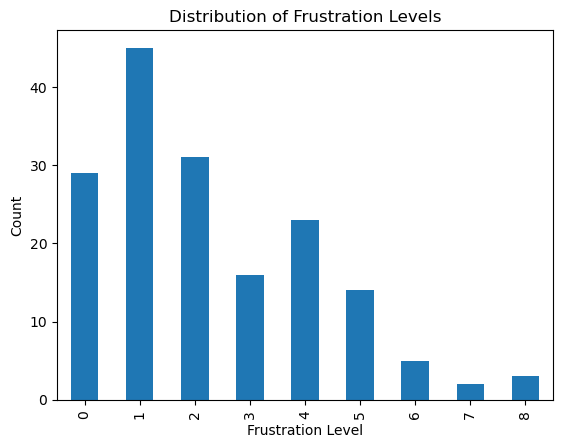

In [104]:
df['Frustrated'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Frustration Levels")
plt.xlabel("Frustration Level")
plt.ylabel("Count")
plt.show()

# Starter med at finde de bedste ANN hyperparametre med GridSearch

In [105]:
# 2) Pipeline 
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ann', MLPClassifier(
        early_stopping=True,
        max_iter=1000,
        random_state=42
    ))
])

param_grid = {
    'ann__hidden_layer_sizes': [
        (10,), (20,), (30,),           # et lag med 10, 20, 30 neuroner
        (30,10), (50,20), (50,30,10),  # To eller tre lag
        (100,), (100,50), (100,50,25)  # Større netværk
    ],
    'ann__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],            
    'ann__learning_rate_init': [1e-4, 1e-3, 5e-3, 1e-2, 5e-2],
    'ann__learning_rate': ['constant', 'adaptive'],
    'ann__solver': ['adam', 'sgd']
}

# Cross-validation 
gkf = GroupKFold(n_splits=5)
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=gkf.split(X, y, groups),
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# grid-search
grid.fit(X, y)

# Resultater
print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)


Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV] END ann__alpha=1e-05, ann__hidden_layer_sizes=(10,), ann__learning_rate=constant, ann__learning_rate_init=0.0001, ann__solver=adam; total time=   0.0s
[CV] END ann__alpha=1e-05, ann__hidden_layer_sizes=(10,), ann__learning_rate=constant, ann__learning_rate_init=0.0001, ann__solver=sgd; total time=   0.0s
[CV] END ann__alpha=1e-05, ann__hidden_layer_sizes=(10,), ann__learning_rate=constant, ann__learning_rate_init=0.0001, ann__solver=adam; total time=   0.0s
[CV] END ann__alpha=1e-05, ann__hidden_layer_sizes=(10,), ann__learning_rate=constant, ann__learning_rate_init=0.0001, ann__solver=adam; total time=   0.0s
[CV] END ann__alpha=1e-05, ann__hidden_layer_sizes=(10,), ann__learning_rate=constant, ann__learning_rate_init=0.0001, ann__solver=sgd; total time=   0.0s
[CV] END ann__alpha=1e-05, ann__hidden_layer_sizes=(10,), ann__learning_rate=constant, ann__learning_rate_init=0.0001, ann__solver=adam; total time=   0.0s
[C

## Finder de samme bare for vores DescicionTree 

In [106]:
dt_pipe = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'dt__max_depth': [2, 3, 4, 5, 6, 8, None],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 5],
    'dt__criterion': ['gini', 'entropy']
}

gkf = GroupKFold(n_splits=5)

dt_grid = GridSearchCV(
    dt_pipe,
    param_grid,
    cv=gkf.split(X, y, groups),
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

dt_grid.fit(X, y)

print("Best params for Decision Tree:", dt_grid.best_params_)
print("Best CV accuracy:", dt_grid.best_score_)


Fitting 5 folds for each of 126 candidates, totalling 630 fits
[CV] END dt__criterion=gini, dt__max_depth=2, dt__min_samples_leaf=1, dt__min_samples_split=2; total time=   0.0s
[CV] END dt__criterion=gini, dt__max_depth=2, dt__min_samples_leaf=1, dt__min_samples_split=2; total time=   0.0s
[CV] END dt__criterion=gini, dt__max_depth=2, dt__min_samples_leaf=1, dt__min_samples_split=5; total time=   0.0s
[CV] END dt__criterion=gini, dt__max_depth=2, dt__min_samples_leaf=1, dt__min_samples_split=10; total time=   0.0s
[CV] END dt__criterion=gini, dt__max_depth=2, dt__min_samples_leaf=1, dt__min_samples_split=2; total time=   0.0s
[CV] END dt__criterion=gini, dt__max_depth=2, dt__min_samples_leaf=1, dt__min_samples_split=2; total time=   0.0s
[CV] END dt__criterion=gini, dt__max_depth=2, dt__min_samples_leaf=1, dt__min_samples_split=2; total time=   0.0s
[CV] END dt__criterion=gini, dt__max_depth=2, dt__min_samples_leaf=2, dt__min_samples_split=2; total time=   0.0s
[CV] END dt__criterion=g

In [107]:
dt_pipe = Pipeline([
    ('dt', DecisionTreeClassifier(
        criterion='gini',
        max_depth=4,
        min_samples_leaf=5,
        min_samples_split=2,
        random_state=42
    ))
])

ann_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ann', MLPClassifier(
        hidden_layer_sizes=(100, 50, 25),
        alpha=0.001,
        learning_rate='constant',
        learning_rate_init=0.05,
        solver='adam',
        max_iter=1000,        
        early_stopping=True,
        n_iter_no_change=20,
        random_state=42
    ))
])

gkf = GroupKFold(n_splits=5)

# til alle scorene
dt_acc, dt_prec, dt_rec, dt_f1 = [], [], [], []
ann_acc, ann_prec, ann_rec, ann_f1 = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups), start=1):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    # Decision Tree
    dt_pipe.fit(X_tr, y_tr)
    y_dt = dt_pipe.predict(X_te)
    a = dt_pipe.score(X_te, y_te)
    p = precision_score(y_te, y_dt, average='macro', zero_division=0)
    r = recall_score   (y_te, y_dt, average='macro', zero_division=0)
    f = f1_score       (y_te, y_dt, average='macro', zero_division=0)
    dt_acc.append(a); dt_prec.append(p); dt_rec.append(r); dt_f1.append(f)
    print(f"DT Fold {fold} — Acc: {a:.3f}, Prec: {p:.3f}, Rec: {r:.3f}, F1: {f:.3f}")

    # ANN
    ann_pipe.fit(X_tr, y_tr)
    y_ann = ann_pipe.predict(X_te)
    a = ann_pipe.score(X_te, y_te)
    p = precision_score(y_te, y_ann, average='macro', zero_division=0)
    r = recall_score   (y_te, y_ann, average='macro', zero_division=0)
    f = f1_score       (y_te, y_ann, average='macro', zero_division=0)
    ann_acc.append(a); ann_prec.append(p); ann_rec.append(r); ann_f1.append(f)
    print(f"ANN Fold {fold} — Acc: {a:.3f}, Prec: {p:.3f}, Rec: {r:.3f}, F1: {f:.3f}")


def summarize(name, arr):
    print(f"{name} mean ± std: {np.mean(arr):.3f} ± {np.std(arr):.3f}")

print("\nDecision Tree:")
summarize("Accuracy", dt_acc)
summarize("Precision", dt_prec)
summarize("Recall",    dt_rec)
summarize("F1-score",  dt_f1)

print("\nANN:")
summarize("Accuracy", ann_acc)
summarize("Precision", ann_prec)
summarize("Recall",    ann_rec)
summarize("F1-score",  ann_f1)


DT Fold 1 — Acc: 0.083, Prec: 0.011, Rec: 0.067, F1: 0.019
ANN Fold 1 — Acc: 0.194, Prec: 0.062, Rec: 0.136, F1: 0.063
DT Fold 2 — Acc: 0.222, Prec: 0.086, Rec: 0.110, F1: 0.092
ANN Fold 2 — Acc: 0.389, Prec: 0.078, Rec: 0.146, F1: 0.101
DT Fold 3 — Acc: 0.194, Prec: 0.083, Rec: 0.119, F1: 0.097
ANN Fold 3 — Acc: 0.194, Prec: 0.072, Rec: 0.096, F1: 0.071
DT Fold 4 — Acc: 0.222, Prec: 0.128, Rec: 0.208, F1: 0.131
ANN Fold 4 — Acc: 0.222, Prec: 0.030, Rec: 0.111, F1: 0.048
DT Fold 5 — Acc: 0.500, Prec: 0.239, Rec: 0.344, F1: 0.278
ANN Fold 5 — Acc: 0.375, Prec: 0.173, Rec: 0.212, F1: 0.189

Decision Tree:
Accuracy mean ± std: 0.244 ± 0.138
Precision mean ± std: 0.109 ± 0.075
Recall mean ± std: 0.170 ± 0.099
F1-score mean ± std: 0.123 ± 0.085

ANN:
Accuracy mean ± std: 0.275 ± 0.088
Precision mean ± std: 0.083 ± 0.048
Recall mean ± std: 0.140 ± 0.040
F1-score mean ± std: 0.094 ± 0.051


## Plotter dem

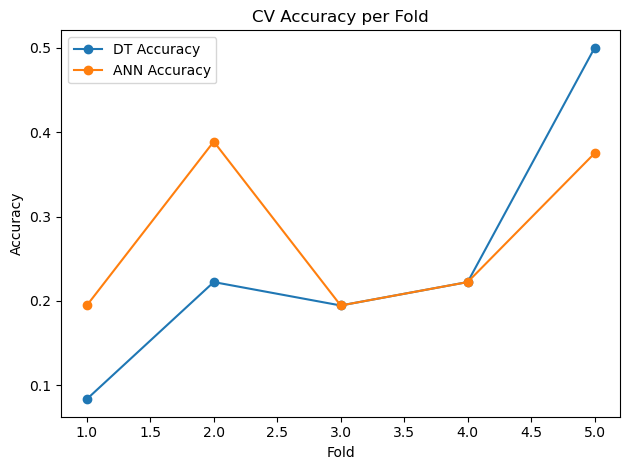

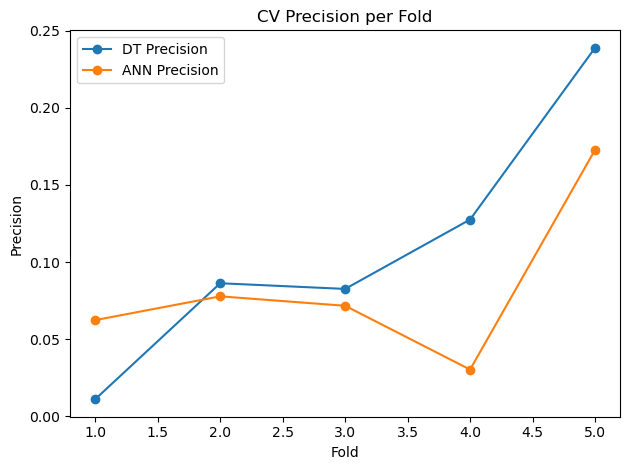

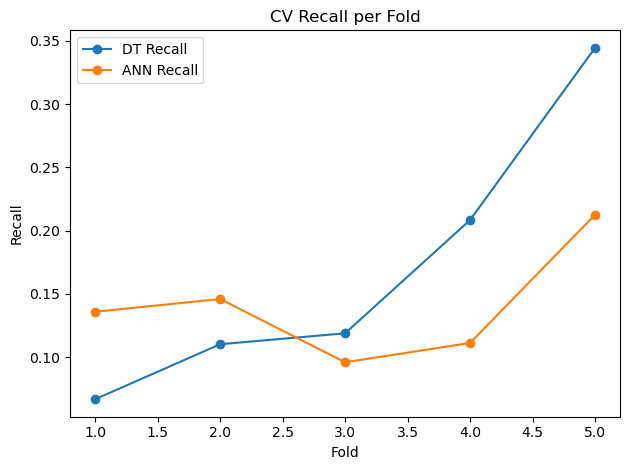

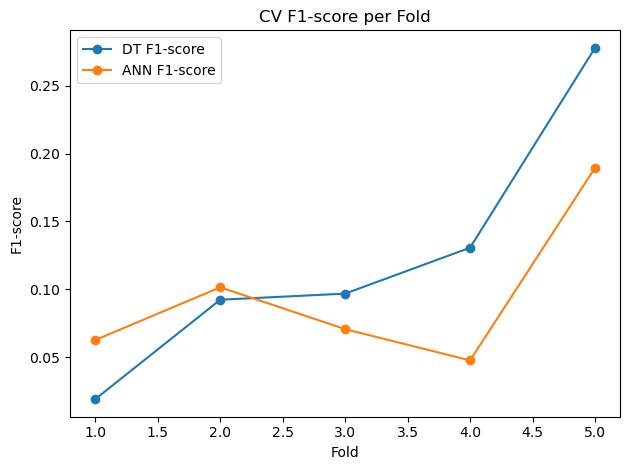

In [108]:
# Plotter alle resultaterne
folds = np.arange(1, len(dt_acc)+1)

# Accuracy
plt.figure()
plt.plot(folds, dt_acc, marker='o', label='DT Accuracy')
plt.plot(folds, ann_acc, marker='o', label='ANN Accuracy')
plt.xlabel('Fold'); plt.ylabel('Accuracy')
plt.title('CV Accuracy per Fold')
plt.legend(); plt.tight_layout(); plt.show()

# Precision
plt.figure()
plt.plot(folds, dt_prec, marker='o', label='DT Precision')
plt.plot(folds, ann_prec, marker='o', label='ANN Precision')
plt.xlabel('Fold'); plt.ylabel('Precision')
plt.title('CV Precision per Fold')
plt.legend(); plt.tight_layout(); plt.show()

# Recall
plt.figure()
plt.plot(folds, dt_rec, marker='o', label='DT Recall')
plt.plot(folds, ann_rec, marker='o', label='ANN Recall')
plt.xlabel('Fold'); plt.ylabel('Recall')
plt.title('CV Recall per Fold')
plt.legend(); plt.tight_layout(); plt.show()

# F1-score
plt.figure()
plt.plot(folds, dt_f1, marker='o', label='DT F1-score')
plt.plot(folds, ann_f1, marker='o', label='ANN F1-score')
plt.xlabel('Fold'); plt.ylabel('F1-score')
plt.title('CV F1-score per Fold')
plt.legend(); plt.tight_layout(); plt.show()


## Tjekker for normalitet: 

In [109]:
diff_acc  = np.array(dt_acc)  - np.array(ann_acc)
diff_prec  = np.array(dt_prec)  - np.array(ann_prec)
diff_rec   = np.array(dt_rec)   - np.array(ann_rec)
diff_f1    = np.array(dt_f1)    - np.array(ann_f1)

Shapiro-Wilk p (Accuracy differences): 0.761
Shapiro-Wilk p (Precision differences): 0.819
Shapiro-Wilk p (Recall differences): 0.692
Shapiro-Wilk p (F1-score differences): 0.514


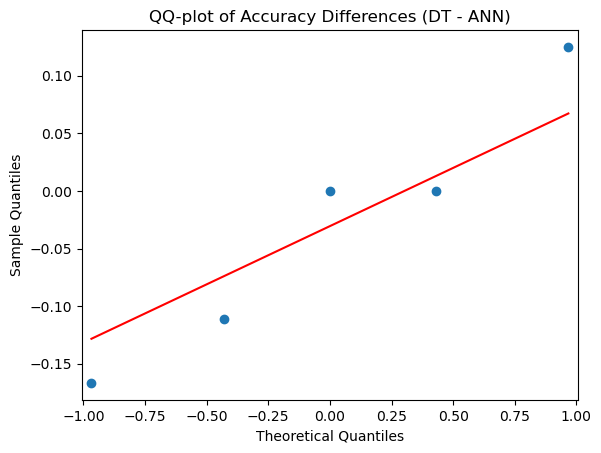

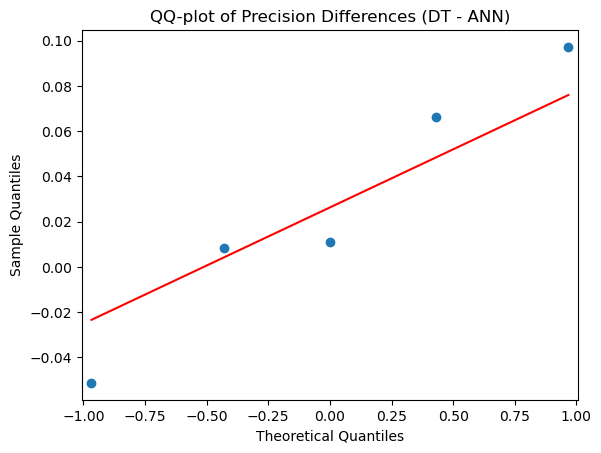

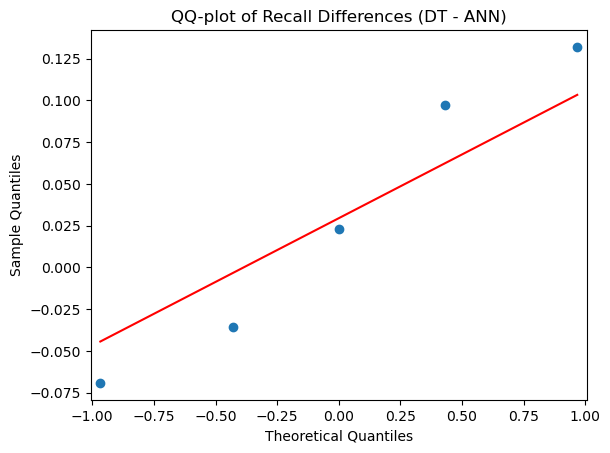

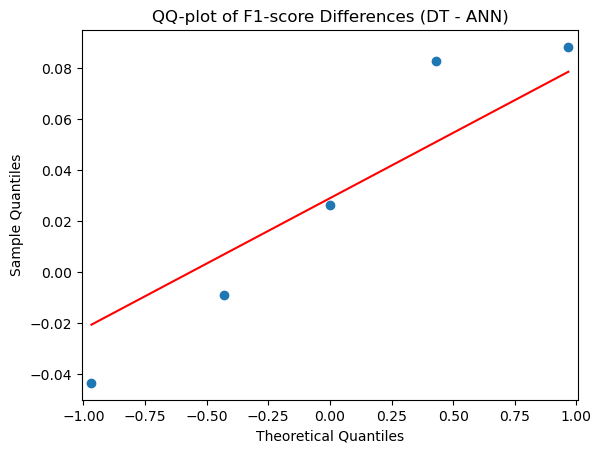

In [115]:
# Shapiro-Wilk test
stat, p_acc = shapiro(diff_acc)
stat, p_prec = shapiro(diff_prec)
stat, p_rec  = shapiro(diff_rec)
stat, p_f1   = shapiro(diff_f1)

print(f"Shapiro-Wilk p (Accuracy differences): {p_acc:.3f}")
print(f"Shapiro-Wilk p (Precision differences): {p_prec:.3f}")
print(f"Shapiro-Wilk p (Recall differences): {p_rec:.3f}")
print(f"Shapiro-Wilk p (F1-score differences): {p_f1:.3f}")

# QQ-plot
sm.qqplot(diff_acc, line='s')
plt.title('QQ-plot of Accuracy Differences (DT - ANN)')
plt.show()

sm.qqplot(diff_prec, line='s')
plt.title('QQ-plot of Precision Differences (DT - ANN)')
plt.show()

sm.qqplot(diff_rec, line='s')
plt.title('QQ-plot of Recall Differences (DT - ANN)')
plt.show()

sm.qqplot(diff_f1, line='s')
plt.title('QQ-plot of F1-score Differences (DT - ANN)')
plt.show()



## Tjekker om der er forskel i accuracy per fold 

In [114]:
# Paired t-test for alle metrics
t_stat, p_val = ttest_rel(dt_acc, ann_acc)
print(f"Paired t-test (Accuracy): t={t_stat:.3f}, p={p_val:.3f}")

t_stat, p_val = ttest_rel(dt_prec, ann_prec)
print(f"Paired t-test (Precision): t={t_stat:.3f}, p={p_val:.3f}")

t_stat, p_val = ttest_rel(dt_rec, ann_rec)
print(f"Paired t-test (Recall): t={t_stat:.3f}, p={p_val:.3f}")

t_stat, p_val = ttest_rel(dt_f1, ann_f1)
print(f"Paired t-test (F1-score): t={t_stat:.3f}, p={p_val:.3f}")

Paired t-test (Accuracy): t=-0.605, p=0.578
Paired t-test (Precision): t=1.025, p=0.363
Paired t-test (Recall): t=0.772, p=0.483
Paired t-test (F1-score): t=1.129, p=0.322
